# Homework 2 Excercise 3 - Image Denoiser

Brennan McFarland
bfm21

In order to denoise an image, we must first create an appropriate representation of it in memory.  We can represent the noisy image as an array of binary pixel values y<sub>i</sub> in {-1, +1} where i is the pixel number, -1 is black and 1 is white.  We can thus derive the most probable denoised image based on the noisy image.

## Load Image

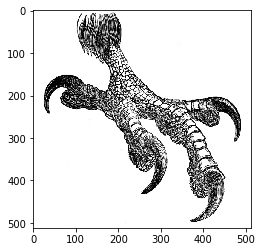

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2dc
from skimage import io

imorg = io.imread('testimage.png', as_grey=True)
plt.imshow(imorg, cmap='gray')

## Add Noise

In [19]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    imnsy[imnsy == 0] = -1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    imnsy[index < nratio] *= -1
    
    return imnsy

In [20]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img, cmap='gray')

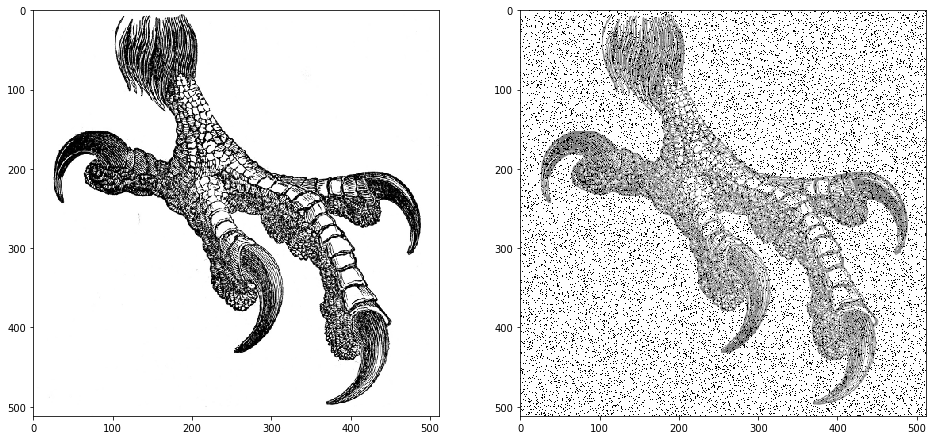

In [22]:
imnsy = addnoise(imorg, nratio = 0.1)
showimgs(imorg, imnsy)

In [6]:
#TODO: make it work for greyscale, not just BW

We can characterize the relationship between pixels as the energy function
$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$
where $\alpha$ is the noise bias, eg, the proportion of white pixels in the image on a scale of [-1, 1],
$\beta$ is the coefficient for the relationship between a pixel and its neighbors for $\beta$>0,
and $\eta$ is the coefficient for the relationship between a pixel's noisy and denoised value for $\eta$>0
Thus the joint distribution over $x$ and $y$ i